<h1>Imports</h1>

In [1]:
import tensorflow as tf
TF_FORCE_GPU_ALLOW_GROWTH= True
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)  
    except RuntimeError as e:
        print(e)
else:
    print("No GPU available. Using the CPU instead.")

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import shap


import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import warnings
warnings.filterwarnings("ignore")

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import Rescaling, RandomZoom, RandomFlip , RandomRotation
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.layers import Dense , Dropout, BatchNormalization , GlobalAveragePooling2D , Conv2D , MaxPooling2D , Flatten
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense , AveragePooling2D , Dropout
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils.model_modifiers import ModelModifier
from tf_keras_vis.utils.scores import CategoricalScore
from tensorflow.keras.applications import MobileNetV2, VGG16, EfficientNetV2B0, EfficientNetV2B3
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import class_weight
from collections import Counter



2024-03-26 10:51:36.758729: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-26 10:51:36.758749: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-26 10:51:36.759287: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-26 10:51:36.762627: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-26 10:51:37.219704: W tensorflow/compiler/tf2

<h1> Load Dataset </h1>

In [2]:

trainining_data_path = 'brain_images/Training/' # Path to folder containing training image data
testing_data = 'brain_images/Testing/' # Path to folder containing testing image data

tf.random.set_seed(123)

BATCH_SIZE = 32 
IMAGE_SIZE = (160, 160)

image_paths_training = []
labels = []

for class_folder in os.listdir(trainining_data_path):
    class_folder_path = os.path.join(trainining_data_path, class_folder)
    if os.path.isdir(class_folder_path):
        for image_file in os.listdir(class_folder_path):
            if image_file.endswith('.jpg') or image_file.endswith('.png'):
                image_paths_training.append(os.path.join(class_folder_path, image_file))
                labels.append(class_folder)

image_paths_testing = []
testing_labels = []

for class_folder in os.listdir(testing_data):
    class_folder_path = os.path.join(testing_data, class_folder)
    if os.path.isdir(class_folder_path):
        for image_file in os.listdir(class_folder_path):
            if image_file.endswith('.jpg') or image_file.endswith('.png'):
                image_paths_testing.append(os.path.join(class_folder_path, image_file))
                testing_labels.append(class_folder)

print("Number of training images: ", len(image_paths_training))
print("Number of testing images: ", len(image_paths_testing))

label_counts_training = Counter(labels)
print("Label counts in training data: ", label_counts_training)

label_counts_testing = Counter(testing_labels)
print("Label counts in testing data: ", label_counts_testing)


Number of training images:  5712
Number of testing images:  1311
Label counts in training data:  Counter({'notumor': 1595, 'pituitary': 1457, 'meningioma': 1339, 'glioma': 1321})
Label counts in testing data:  Counter({'notumor': 405, 'meningioma': 306, 'pituitary': 300, 'glioma': 300})


<h1> Visualising Dataset</h1>

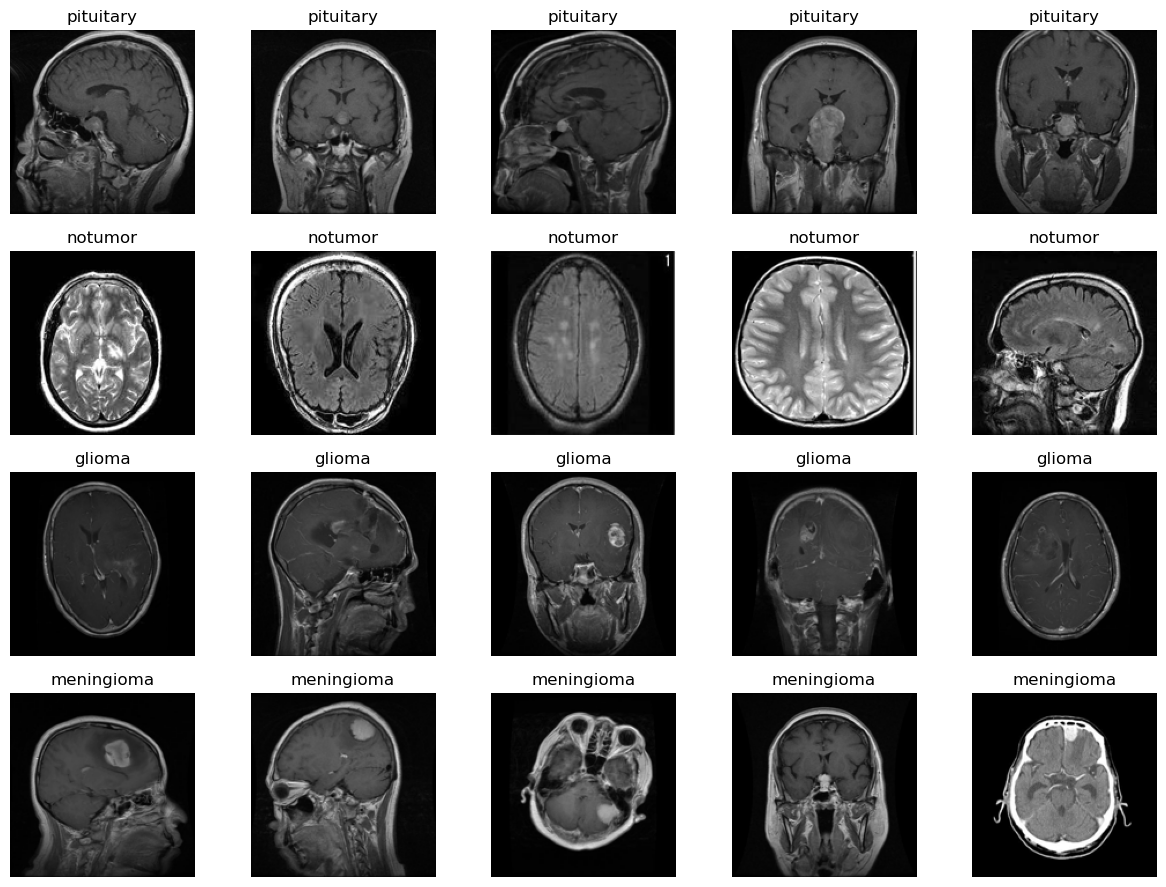

In [3]:
from PIL import Image
from collections import defaultdict

def load_images(image_paths, target_size):
    return np.array([np.array(Image.open(path).convert('RGB').resize(target_size)) for path in image_paths])

def plotImages(images, labels):
    plt.figure(figsize=[15,11])                 
    
    images_by_class = defaultdict(list)
    for image, label in zip(images, labels):
        images_by_class[label].append(image)
    
    selected_images = [image for images in images_by_class.values() for image in images[:5]]
    selected_labels = [label for label, images in images_by_class.items() for image in images[:5]]
    
    for i in range(len(selected_images)):
        plt.subplot(len(images_by_class), 5, i+1)  
        plt.imshow(selected_images[i])             
        plt.title(selected_labels[i])              
        plt.axis("off")
    plt.show()

images = load_images(image_paths_training, IMAGE_SIZE)

plotImages(images, labels)

<h1> Model </h1>

In [4]:
from keras.regularizers import l2
from keras.layers import Input

def create_model():
    dropout_rate = 0.5 

    input_tensor = Input(shape=IMAGE_SIZE + (3,))
    EfficientNetV2B0_model = EfficientNetV2B0(input_shape=IMAGE_SIZE + (3,), weights='imagenet', include_top=False, pooling='max', input_tensor=input_tensor)

    out_relu = EfficientNetV2B0_model.layers[-1]
    x = Dropout(dropout_rate)(out_relu.output)
    x = BatchNormalization()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(4, activation='softmax')(x)
    model = Model(inputs=input_tensor, outputs=x)
    model.compile(optimizer=tf.keras.optimizers.Adamax(learning_rate = 0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

    
    return model

<h1>K-cross validation</h1>

In [5]:

skf = StratifiedKFold(n_splits=5 ,shuffle=True, random_state=123)

models_and_scores = []
class_names = []

test_generator = None

for train_index, val_index in skf.split(image_paths_training, labels):
    train_paths, val_paths = np.array(image_paths_training)[train_index], np.array(image_paths_training)[val_index]
    train_labels, val_labels = np.array(labels)[train_index], np.array(labels)[val_index]
    
    train_df = pd.DataFrame({'path': train_paths, 'label': train_labels})
    val_df = pd.DataFrame({'path': val_paths, 'label': val_labels})
    test_df = pd.DataFrame({'path': image_paths_testing, 'label': testing_labels})

    print("Train class distribution: ", train_df['label'].value_counts())


    # train_datagen = IDG(
    #             shear_range= 0.3,  
    #             zoom_range = 0.4,  
    #             width_shift_range = 0.3,  
    #             height_shift_range = 0.3,
    #             horizontal_flip=True,
    #             rotation_range=20,
    #             fill_mode = "nearest")
    
    train_datagen = IDG()
    
    train_datagen_rescaled = IDG(
                rescale=1./255,
                shear_range= 0.3,  
                zoom_range = 0.4,  
                width_shift_range = 0.3,  
                height_shift_range = 0.3,
                horizontal_flip=True,
                fill_mode = "nearest")
    

    val_datagen = IDG()

    val_datagen_rescaled = IDG(
                rescale=1./255,)
    

    test_datagen = IDG()

    test_datagen_rescaled = IDG(
                rescale=1./255,
    )

    train_generator = train_datagen.flow_from_dataframe(train_df, x_col='path', y_col='label', target_size=IMAGE_SIZE, class_mode='categorical', shuffle=True, color_mode='rgb', batch_size = BATCH_SIZE)
    val_generator = val_datagen.flow_from_dataframe(val_df, x_col='path', y_col='label', target_size=IMAGE_SIZE, class_mode='categorical', shuffle=True, color_mode='rgb', batch_size = BATCH_SIZE)
    test_generator = test_datagen.flow_from_dataframe(test_df, x_col='path', y_col='label', target_size=IMAGE_SIZE, class_mode='categorical', shuffle=True, color_mode='rgb', batch_size = BATCH_SIZE)

    train_generator_rescaled = train_datagen_rescaled.flow_from_dataframe(train_df, x_col='path', y_col='label', target_size=IMAGE_SIZE, class_mode='categorical', shuffle=True, color_mode='rgb', batch_size = BATCH_SIZE)
    val_generator_rescaled = val_datagen_rescaled.flow_from_dataframe(val_df, x_col='path', y_col='label', target_size=IMAGE_SIZE, class_mode='categorical', shuffle=True, color_mode='rgb', batch_size = BATCH_SIZE)
    test_generator_rescaled= test_datagen_rescaled.flow_from_dataframe(test_df, x_col='path', y_col='label', target_size=IMAGE_SIZE, class_mode='categorical', shuffle=True, color_mode='rgb', batch_size = BATCH_SIZE)

    class_names = list(test_generator.class_indices)
    
    model = create_model()  

    class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
    class_weights = dict(enumerate(class_weights))

    model.fit(train_generator, epochs=15, validation_data=val_generator, class_weight=class_weights, verbose = 1)

    score = model.evaluate(test_generator)
    print(score)

    models_and_scores.append((model, score))

best_model, best_score = max(models_and_scores, key=lambda x: x[1][1])

Train class distribution:  label
notumor       1276
pituitary     1165
meningioma    1071
glioma        1057
Name: count, dtype: int64
Found 4569 validated image filenames belonging to 4 classes.
Found 1143 validated image filenames belonging to 4 classes.
Found 1311 validated image filenames belonging to 4 classes.
Found 4569 validated image filenames belonging to 4 classes.
Found 1143 validated image filenames belonging to 4 classes.
Found 1311 validated image filenames belonging to 4 classes.


2024-03-26 10:51:52.351519: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-26 10:51:52.351681: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-26 10:51:52.351829: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Epoch 1/15


2024-03-26 10:52:01.592655: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-03-26 10:52:02.884865: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-03-26 10:52:04.150103: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f8f8c335f30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-26 10:52:04.150123: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2024-03-26 10:52:04.152867: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1711450324.213589  221890 device_compiler.h:186] Compiled cluster using XL

143/143 [==============================] - 30s 76ms/step - loss: 1.6571 - accuracy: 0.4049 - val_loss: 0.5884 - val_accuracy: 0.7944
Epoch 2/15
143/143 [==============================] - 9s 61ms/step - loss: 1.0379 - accuracy: 0.6255 - val_loss: 0.3931 - val_accuracy: 0.8618
Epoch 3/15
143/143 [==============================] - 9s 61ms/step - loss: 0.7478 - accuracy: 0.7367 - val_loss: 0.3393 - val_accuracy: 0.8801
Epoch 4/15
143/143 [==============================] - 9s 62ms/step - loss: 0.6374 - accuracy: 0.7827 - val_loss: 0.3109 - val_accuracy: 0.8994
Epoch 5/15
143/143 [==============================] - 9s 64ms/step - loss: 0.5075 - accuracy: 0.8317 - val_loss: 0.2857 - val_accuracy: 0.9029
Epoch 6/15
143/143 [==============================] - 9s 60ms/step - loss: 0.4489 - accuracy: 0.8472 - val_loss: 0.2632 - val_accuracy: 0.9151
Epoch 7/15
143/143 [==============================] - 9s 62ms/step - loss: 0.3881 - accuracy: 0.8661 - val_loss: 0.2375 - val_accuracy: 0.9160
Epoch 8/1

2024-03-26 10:54:40.922425: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


143/143 [==============================] - 25s 68ms/step - loss: 1.6822 - accuracy: 0.3931 - val_loss: 0.6346 - val_accuracy: 0.7778
Epoch 2/15
143/143 [==============================] - 9s 61ms/step - loss: 1.0436 - accuracy: 0.6286 - val_loss: 0.4391 - val_accuracy: 0.8451
Epoch 3/15
143/143 [==============================] - 9s 61ms/step - loss: 0.7824 - accuracy: 0.7262 - val_loss: 0.3635 - val_accuracy: 0.8740
Epoch 4/15
143/143 [==============================] - 9s 59ms/step - loss: 0.6239 - accuracy: 0.7881 - val_loss: 0.3017 - val_accuracy: 0.8889
Epoch 5/15
143/143 [==============================] - 9s 59ms/step - loss: 0.5279 - accuracy: 0.8212 - val_loss: 0.2714 - val_accuracy: 0.8976
Epoch 6/15
143/143 [==============================] - 9s 60ms/step - loss: 0.4549 - accuracy: 0.8418 - val_loss: 0.2272 - val_accuracy: 0.9090
Epoch 7/15
143/143 [==============================] - 9s 64ms/step - loss: 0.3851 - accuracy: 0.8671 - val_loss: 0.2165 - val_accuracy: 0.9195
Epoch 8/1

2024-03-26 10:57:13.141195: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_2/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


143/143 [==============================] - 28s 82ms/step - loss: 1.8420 - accuracy: 0.3985 - val_loss: 0.6548 - val_accuracy: 0.7574
Epoch 2/15
143/143 [==============================] - 9s 63ms/step - loss: 1.1264 - accuracy: 0.6168 - val_loss: 0.4022 - val_accuracy: 0.8660
Epoch 3/15
143/143 [==============================] - 8s 58ms/step - loss: 0.8000 - accuracy: 0.7223 - val_loss: 0.3059 - val_accuracy: 0.8940
Epoch 4/15
143/143 [==============================] - 8s 58ms/step - loss: 0.6765 - accuracy: 0.7753 - val_loss: 0.2684 - val_accuracy: 0.9159
Epoch 5/15
143/143 [==============================] - 9s 60ms/step - loss: 0.5267 - accuracy: 0.8274 - val_loss: 0.2257 - val_accuracy: 0.9168
Epoch 6/15
143/143 [==============================] - 9s 64ms/step - loss: 0.4648 - accuracy: 0.8363 - val_loss: 0.2024 - val_accuracy: 0.9308
Epoch 7/15
143/143 [==============================] - 9s 62ms/step - loss: 0.3961 - accuracy: 0.8689 - val_loss: 0.1800 - val_accuracy: 0.9308
Epoch 8/1

2024-03-26 10:59:45.103192: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_3/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


143/143 [==============================] - 24s 66ms/step - loss: 1.6643 - accuracy: 0.3972 - val_loss: 0.5770 - val_accuracy: 0.8109
Epoch 2/15
143/143 [==============================] - 9s 60ms/step - loss: 1.0197 - accuracy: 0.6230 - val_loss: 0.3895 - val_accuracy: 0.8625
Epoch 3/15
143/143 [==============================] - 9s 60ms/step - loss: 0.7871 - accuracy: 0.7212 - val_loss: 0.3365 - val_accuracy: 0.8844
Epoch 4/15
143/143 [==============================] - 9s 61ms/step - loss: 0.6138 - accuracy: 0.7869 - val_loss: 0.2704 - val_accuracy: 0.9063
Epoch 5/15
143/143 [==============================] - 9s 60ms/step - loss: 0.4848 - accuracy: 0.8372 - val_loss: 0.2390 - val_accuracy: 0.9168
Epoch 6/15
143/143 [==============================] - 9s 60ms/step - loss: 0.4478 - accuracy: 0.8503 - val_loss: 0.2154 - val_accuracy: 0.9194
Epoch 7/15
143/143 [==============================] - 9s 60ms/step - loss: 0.3609 - accuracy: 0.8751 - val_loss: 0.1900 - val_accuracy: 0.9308
Epoch 8/1

2024-03-26 11:02:13.528246: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_4/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


143/143 [==============================] - 24s 66ms/step - loss: 1.5829 - accuracy: 0.4254 - val_loss: 0.5679 - val_accuracy: 0.8275
Epoch 2/15
143/143 [==============================] - 9s 60ms/step - loss: 1.0570 - accuracy: 0.6173 - val_loss: 0.3936 - val_accuracy: 0.8757
Epoch 3/15
143/143 [==============================] - 9s 60ms/step - loss: 0.7920 - accuracy: 0.7265 - val_loss: 0.3249 - val_accuracy: 0.8862
Epoch 4/15
143/143 [==============================] - 9s 60ms/step - loss: 0.6130 - accuracy: 0.7897 - val_loss: 0.2824 - val_accuracy: 0.9019
Epoch 5/15
143/143 [==============================] - 9s 60ms/step - loss: 0.5352 - accuracy: 0.8225 - val_loss: 0.2319 - val_accuracy: 0.9133
Epoch 6/15
143/143 [==============================] - 8s 59ms/step - loss: 0.4372 - accuracy: 0.8514 - val_loss: 0.2223 - val_accuracy: 0.9203
Epoch 7/15
143/143 [==============================] - 9s 60ms/step - loss: 0.3714 - accuracy: 0.8759 - val_loss: 0.1956 - val_accuracy: 0.9352
Epoch 8/1

<h1> Grad-Cam</h1>

1/1 [==============================] - 0s 22ms/step - loss: 0.0399 - accuracy: 1.0000


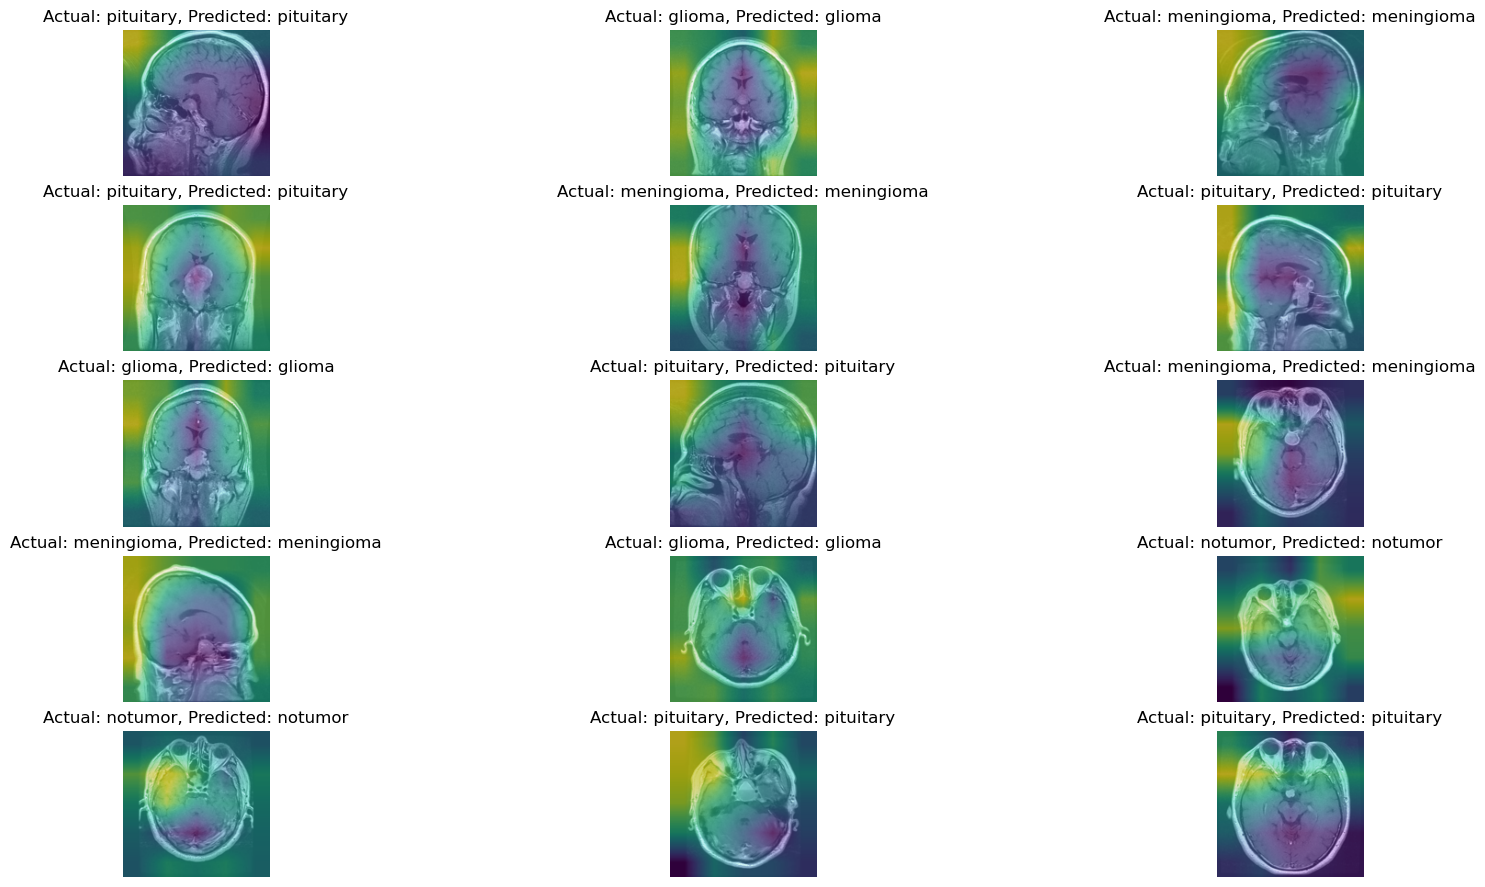

In [36]:
from tf_explain.core.grad_cam import GradCAM as GradCAME

images_list, labels_list = [], []

for _ in range(len(test_generator)):
    images_batch, labels_batch = next(test_generator)
    images_list.extend(images_batch)
    labels_list.extend(labels_batch)


indices = np.random.choice(len(images_list), size=15, replace=False)


random_images = np.array([images_list[i] for i in indices])
random_labels = [labels_list[i] for i in indices]


predictions = best_model.predict(random_images)


evaluations = best_model.evaluate(random_images, np.array(random_labels))


predicted_classes = np.argmax(predictions, axis=1)

actual_classes = [np.argmax(label) for label in random_labels]

gradcam = GradcamPlusPlus(best_model)

explainer = GradCAME()

plt.figure(figsize=(20, 11))

for i, (image, actual_class, predicted_class) in enumerate(zip(images, actual_classes, predicted_classes)):
    grid = explainer.explain(([image], None), best_model, predicted_class, layer_name='top_conv')

    plt.subplot(5, 3, i + 1)
    
    plt.imshow(image, alpha=1.0)
    
    plt.imshow(grid, cmap='hot', alpha=0.7)
    
    plt.title(f"Actual: {class_names[actual_class]}, Predicted: {class_names[predicted_class]}")
    plt.axis("off")

plt.show()

<h1>Lime</h1>

  0%|          | 0/300 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step


 10%|█         | 30/300 [00:00<00:01, 226.24it/s]

1/1 [==============================] - 0s 15ms/step


 20%|██        | 60/300 [00:00<00:00, 241.11it/s]

1/1 [==============================] - 0s 13ms/step


 30%|███       | 90/300 [00:00<00:00, 247.22it/s]

1/1 [==============================] - 0s 13ms/step


 40%|████      | 120/300 [00:00<00:00, 247.60it/s]

1/1 [==============================] - 0s 13ms/step


 50%|█████     | 150/300 [00:00<00:00, 252.00it/s]

1/1 [==============================] - 0s 14ms/step


 60%|██████    | 180/300 [00:00<00:00, 245.56it/s]

1/1 [==============================] - 0s 14ms/step


 70%|███████   | 210/300 [00:00<00:00, 240.71it/s]

1/1 [==============================] - 0s 14ms/step


 80%|████████  | 240/300 [00:00<00:00, 242.54it/s]

1/1 [==============================] - 0s 13ms/step


 90%|█████████ | 270/300 [00:01<00:00, 244.82it/s]

1/1 [==============================] - 0s 13ms/step


100%|██████████| 300/300 [00:01<00:00, 245.05it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  0%|          | 0/300 [00:00<?, ?it/s]

1/1 [==============================] - 0s 14ms/step


 10%|█         | 30/300 [00:00<00:01, 239.43it/s]

1/1 [==============================] - 0s 15ms/step


 20%|██        | 60/300 [00:00<00:00, 245.12it/s]

1/1 [==============================] - 0s 13ms/step


 30%|███       | 90/300 [00:00<00:00, 246.47it/s]

1/1 [==============================] - 0s 14ms/step


 40%|████      | 120/300 [00:00<00:00, 240.73it/s]

1/1 [==============================] - 0s 13ms/step


 50%|█████     | 150/300 [00:00<00:00, 236.52it/s]

1/1 [==============================] - 0s 13ms/step


 60%|██████    | 180/300 [00:00<00:00, 242.09it/s]

1/1 [==============================] - 0s 13ms/step


 70%|███████   | 210/300 [00:00<00:00, 244.93it/s]

1/1 [==============================] - 0s 13ms/step


 80%|████████  | 240/300 [00:00<00:00, 244.83it/s]

1/1 [==============================] - 0s 13ms/step


 90%|█████████ | 270/300 [00:01<00:00, 246.76it/s]

1/1 [==============================] - 0s 14ms/step


100%|██████████| 300/300 [00:01<00:00, 245.11it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  0%|          | 0/300 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step


 10%|█         | 30/300 [00:00<00:01, 252.69it/s]

1/1 [==============================] - 0s 13ms/step


 20%|██        | 60/300 [00:00<00:00, 254.90it/s]

1/1 [==============================] - 0s 13ms/step


 30%|███       | 90/300 [00:00<00:00, 245.15it/s]

1/1 [==============================] - 0s 13ms/step


 40%|████      | 120/300 [00:00<00:00, 247.97it/s]

1/1 [==============================] - 0s 13ms/step


 50%|█████     | 150/300 [00:00<00:00, 247.25it/s]

1/1 [==============================] - 0s 13ms/step


 60%|██████    | 180/300 [00:00<00:00, 248.92it/s]

1/1 [==============================] - 0s 14ms/step


 70%|███████   | 210/300 [00:00<00:00, 247.16it/s]

1/1 [==============================] - 0s 13ms/step


 80%|████████  | 240/300 [00:00<00:00, 250.56it/s]

1/1 [==============================] - 0s 14ms/step


 90%|█████████ | 270/300 [00:01<00:00, 247.67it/s]

1/1 [==============================] - 0s 13ms/step


100%|██████████| 300/300 [00:01<00:00, 249.60it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  0%|          | 0/300 [00:00<?, ?it/s]

1/1 [==============================] - 0s 14ms/step


 10%|█         | 30/300 [00:00<00:01, 247.93it/s]

1/1 [==============================] - 0s 14ms/step


 20%|██        | 60/300 [00:00<00:01, 234.49it/s]

1/1 [==============================] - 0s 13ms/step


 30%|███       | 90/300 [00:00<00:00, 237.52it/s]

1/1 [==============================] - 0s 13ms/step


 40%|████      | 120/300 [00:00<00:00, 242.29it/s]

1/1 [==============================] - 0s 13ms/step


 50%|█████     | 150/300 [00:00<00:00, 246.06it/s]

1/1 [==============================] - 0s 14ms/step


 60%|██████    | 180/300 [00:00<00:00, 244.80it/s]

1/1 [==============================] - 0s 13ms/step


 70%|███████   | 210/300 [00:00<00:00, 248.73it/s]

1/1 [==============================] - 0s 13ms/step


 80%|████████  | 240/300 [00:00<00:00, 250.88it/s]

1/1 [==============================] - 0s 14ms/step


 90%|█████████ | 270/300 [00:01<00:00, 248.60it/s]

1/1 [==============================] - 0s 13ms/step


100%|██████████| 300/300 [00:01<00:00, 246.87it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  0%|          | 0/300 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step


 10%|█         | 30/300 [00:00<00:01, 240.26it/s]

1/1 [==============================] - 0s 13ms/step


 20%|██        | 60/300 [00:00<00:01, 239.89it/s]

1/1 [==============================] - 0s 13ms/step


 30%|███       | 90/300 [00:00<00:00, 245.34it/s]

1/1 [==============================] - 0s 13ms/step


 40%|████      | 120/300 [00:00<00:00, 246.85it/s]

1/1 [==============================] - 0s 13ms/step


 50%|█████     | 150/300 [00:00<00:00, 248.97it/s]

1/1 [==============================] - 0s 14ms/step


 60%|██████    | 180/300 [00:00<00:00, 243.21it/s]

1/1 [==============================] - 0s 13ms/step


 70%|███████   | 210/300 [00:00<00:00, 244.78it/s]

1/1 [==============================] - 0s 13ms/step


 80%|████████  | 240/300 [00:00<00:00, 247.61it/s]

1/1 [==============================] - 0s 14ms/step


 90%|█████████ | 270/300 [00:01<00:00, 244.89it/s]

1/1 [==============================] - 0s 14ms/step


100%|██████████| 300/300 [00:01<00:00, 245.23it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  0%|          | 0/300 [00:00<?, ?it/s]

1/1 [==============================] - 0s 14ms/step


 10%|█         | 30/300 [00:00<00:01, 242.81it/s]

1/1 [==============================] - 0s 14ms/step


 20%|██        | 60/300 [00:00<00:00, 245.38it/s]

1/1 [==============================] - 0s 14ms/step


 30%|███       | 90/300 [00:00<00:00, 244.11it/s]

1/1 [==============================] - 0s 13ms/step


 40%|████      | 120/300 [00:00<00:00, 249.75it/s]

1/1 [==============================] - 0s 13ms/step


 50%|█████     | 150/300 [00:00<00:00, 252.98it/s]

1/1 [==============================] - 0s 15ms/step


 60%|██████    | 180/300 [00:00<00:00, 249.95it/s]

1/1 [==============================] - 0s 13ms/step


 70%|███████   | 210/300 [00:00<00:00, 240.93it/s]

1/1 [==============================] - 0s 14ms/step


 80%|████████  | 240/300 [00:00<00:00, 244.32it/s]

1/1 [==============================] - 0s 13ms/step


 90%|█████████ | 270/300 [00:01<00:00, 247.93it/s]

1/1 [==============================] - 0s 13ms/step


100%|██████████| 300/300 [00:01<00:00, 248.52it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  0%|          | 0/300 [00:00<?, ?it/s]

1/1 [==============================] - 0s 14ms/step


 10%|█         | 30/300 [00:00<00:01, 249.46it/s]

1/1 [==============================] - 0s 13ms/step


 20%|██        | 60/300 [00:00<00:00, 253.30it/s]

1/1 [==============================] - 0s 12ms/step


 30%|███       | 90/300 [00:00<00:00, 257.29it/s]

1/1 [==============================] - 0s 13ms/step


 40%|████      | 120/300 [00:00<00:00, 251.85it/s]

1/1 [==============================] - 0s 15ms/step


 50%|█████     | 150/300 [00:00<00:00, 242.16it/s]

1/1 [==============================] - 0s 13ms/step


 60%|██████    | 180/300 [00:00<00:00, 247.02it/s]

1/1 [==============================] - 0s 12ms/step


 70%|███████   | 210/300 [00:00<00:00, 250.18it/s]

1/1 [==============================] - 0s 13ms/step


 80%|████████  | 240/300 [00:00<00:00, 249.75it/s]

1/1 [==============================] - 0s 13ms/step


 90%|█████████ | 270/300 [00:01<00:00, 251.76it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████| 300/300 [00:01<00:00, 250.39it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  0%|          | 0/300 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step


 10%|█         | 30/300 [00:00<00:01, 248.41it/s]

1/1 [==============================] - 0s 12ms/step


 20%|██        | 60/300 [00:00<00:00, 253.36it/s]

1/1 [==============================] - 0s 15ms/step


 30%|███       | 90/300 [00:00<00:00, 247.81it/s]

1/1 [==============================] - 0s 14ms/step


 40%|████      | 120/300 [00:00<00:00, 250.01it/s]

1/1 [==============================] - 0s 13ms/step


 50%|█████     | 150/300 [00:00<00:00, 250.91it/s]

1/1 [==============================] - 0s 14ms/step


 60%|██████    | 180/300 [00:00<00:00, 252.42it/s]

1/1 [==============================] - 0s 13ms/step


 70%|███████   | 210/300 [00:00<00:00, 254.71it/s]

1/1 [==============================] - 0s 14ms/step


 80%|████████  | 240/300 [00:00<00:00, 247.58it/s]

1/1 [==============================] - 0s 13ms/step


 90%|█████████ | 270/300 [00:01<00:00, 250.23it/s]

1/1 [==============================] - 0s 13ms/step


100%|██████████| 300/300 [00:01<00:00, 250.85it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  0%|          | 0/300 [00:00<?, ?it/s]

1/1 [==============================] - 0s 14ms/step


 10%|█         | 30/300 [00:00<00:01, 229.59it/s]

1/1 [==============================] - 0s 13ms/step


 20%|██        | 60/300 [00:00<00:00, 243.73it/s]

1/1 [==============================] - 0s 14ms/step


 30%|███       | 90/300 [00:00<00:00, 248.73it/s]

1/1 [==============================] - 0s 14ms/step


 40%|████      | 120/300 [00:00<00:00, 250.99it/s]

1/1 [==============================] - 0s 13ms/step


 50%|█████     | 150/300 [00:00<00:00, 247.85it/s]

1/1 [==============================] - 0s 13ms/step


 60%|██████    | 180/300 [00:00<00:00, 251.13it/s]

1/1 [==============================] - 0s 13ms/step


 70%|███████   | 210/300 [00:00<00:00, 253.74it/s]

1/1 [==============================] - 0s 13ms/step


 80%|████████  | 240/300 [00:00<00:00, 254.53it/s]

1/1 [==============================] - 0s 14ms/step


 90%|█████████ | 270/300 [00:01<00:00, 244.06it/s]

1/1 [==============================] - 0s 13ms/step


100%|██████████| 300/300 [00:01<00:00, 247.68it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  0%|          | 0/300 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step


 10%|█         | 30/300 [00:00<00:01, 251.33it/s]

1/1 [==============================] - 0s 14ms/step


 20%|██        | 60/300 [00:00<00:00, 243.36it/s]

1/1 [==============================] - 0s 13ms/step


 30%|███       | 90/300 [00:00<00:00, 245.48it/s]

1/1 [==============================] - 0s 13ms/step


 40%|████      | 120/300 [00:00<00:00, 248.46it/s]

1/1 [==============================] - 0s 13ms/step


 50%|█████     | 150/300 [00:00<00:00, 250.71it/s]

1/1 [==============================] - 0s 13ms/step


 60%|██████    | 180/300 [00:00<00:00, 246.74it/s]

1/1 [==============================] - 0s 14ms/step


 70%|███████   | 210/300 [00:00<00:00, 237.86it/s]

1/1 [==============================] - 0s 13ms/step


 80%|████████  | 240/300 [00:00<00:00, 243.62it/s]

1/1 [==============================] - 0s 13ms/step


 90%|█████████ | 270/300 [00:01<00:00, 246.18it/s]

1/1 [==============================] - 0s 13ms/step


100%|██████████| 300/300 [00:01<00:00, 246.71it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  0%|          | 0/300 [00:00<?, ?it/s]

1/1 [==============================] - 0s 14ms/step


 10%|█         | 30/300 [00:00<00:01, 256.62it/s]

1/1 [==============================] - 0s 14ms/step


 20%|██        | 60/300 [00:00<00:01, 240.00it/s]

1/1 [==============================] - 0s 14ms/step


 30%|███       | 90/300 [00:00<00:00, 245.13it/s]

1/1 [==============================] - 0s 13ms/step


 40%|████      | 120/300 [00:00<00:00, 245.74it/s]

1/1 [==============================] - 0s 13ms/step


 50%|█████     | 150/300 [00:00<00:00, 240.85it/s]

1/1 [==============================] - 0s 13ms/step


 60%|██████    | 180/300 [00:00<00:00, 244.19it/s]

1/1 [==============================] - 0s 13ms/step


 70%|███████   | 210/300 [00:00<00:00, 249.83it/s]

1/1 [==============================] - 0s 13ms/step


 80%|████████  | 240/300 [00:00<00:00, 251.78it/s]

1/1 [==============================] - 0s 13ms/step


 90%|█████████ | 270/300 [00:01<00:00, 254.55it/s]

1/1 [==============================] - 0s 13ms/step


100%|██████████| 300/300 [00:01<00:00, 248.61it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  0%|          | 0/300 [00:00<?, ?it/s]

1/1 [==============================] - 0s 14ms/step


 10%|█         | 30/300 [00:00<00:01, 237.33it/s]

1/1 [==============================] - 0s 13ms/step


 20%|██        | 60/300 [00:00<00:00, 245.69it/s]

1/1 [==============================] - 0s 13ms/step


 29%|██▉       | 87/300 [00:00<00:00, 255.24it/s]

1/1 [==============================] - 0s 13ms/step


 38%|███▊      | 113/300 [00:00<00:00, 221.86it/s]

1/1 [==============================] - 0s 12ms/step


 47%|████▋     | 140/300 [00:00<00:00, 222.14it/s]

1/1 [==============================] - 0s 13ms/step


 57%|█████▋    | 170/300 [00:00<00:00, 231.83it/s]

1/1 [==============================] - 0s 14ms/step


 67%|██████▋   | 200/300 [00:00<00:00, 234.98it/s]

1/1 [==============================] - 0s 13ms/step


 77%|███████▋  | 230/300 [00:00<00:00, 240.54it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 260/300 [00:01<00:00, 236.76it/s]

1/1 [==============================] - 0s 15ms/step


 95%|█████████▍| 284/300 [00:01<00:00, 237.49it/s]

1/1 [==============================] - 0s 13ms/step


100%|██████████| 300/300 [00:01<00:00, 233.60it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  0%|          | 0/300 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step


 10%|█         | 30/300 [00:00<00:01, 251.93it/s]

1/1 [==============================] - 0s 13ms/step


 20%|██        | 60/300 [00:00<00:00, 254.37it/s]

1/1 [==============================] - 0s 14ms/step


 30%|███       | 90/300 [00:00<00:00, 253.01it/s]

1/1 [==============================] - 0s 14ms/step


 40%|████      | 120/300 [00:00<00:00, 248.56it/s]

1/1 [==============================] - 0s 13ms/step


 50%|█████     | 150/300 [00:00<00:00, 251.48it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 180/300 [00:00<00:00, 246.31it/s]

1/1 [==============================] - 0s 13ms/step


 70%|███████   | 210/300 [00:00<00:00, 249.07it/s]

1/1 [==============================] - 0s 13ms/step


 80%|████████  | 240/300 [00:00<00:00, 248.55it/s]

1/1 [==============================] - 0s 13ms/step


 90%|█████████ | 270/300 [00:01<00:00, 252.48it/s]

1/1 [==============================] - 0s 13ms/step


100%|██████████| 300/300 [00:01<00:00, 251.97it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  0%|          | 0/300 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step


 10%|█         | 30/300 [00:00<00:01, 241.52it/s]

1/1 [==============================] - 0s 13ms/step


 20%|██        | 60/300 [00:00<00:00, 244.23it/s]

1/1 [==============================] - 0s 13ms/step


 30%|███       | 90/300 [00:00<00:00, 249.28it/s]

1/1 [==============================] - 0s 13ms/step


 40%|████      | 120/300 [00:00<00:00, 241.15it/s]

1/1 [==============================] - 0s 13ms/step


 50%|█████     | 150/300 [00:00<00:00, 247.28it/s]

1/1 [==============================] - 0s 13ms/step


 60%|██████    | 180/300 [00:00<00:00, 250.38it/s]

1/1 [==============================] - 0s 13ms/step


 70%|███████   | 210/300 [00:00<00:00, 253.44it/s]

1/1 [==============================] - 0s 14ms/step


 80%|████████  | 240/300 [00:00<00:00, 251.51it/s]

1/1 [==============================] - 0s 13ms/step


 90%|█████████ | 270/300 [00:01<00:00, 249.64it/s]

1/1 [==============================] - 0s 13ms/step


100%|██████████| 300/300 [00:01<00:00, 248.69it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  0%|          | 0/300 [00:00<?, ?it/s]

1/1 [==============================] - 0s 14ms/step


 10%|█         | 30/300 [00:00<00:01, 240.15it/s]

1/1 [==============================] - 0s 14ms/step


 20%|██        | 60/300 [00:00<00:00, 242.00it/s]

1/1 [==============================] - 0s 13ms/step


 30%|███       | 90/300 [00:00<00:00, 245.73it/s]

1/1 [==============================] - 0s 13ms/step


 40%|████      | 120/300 [00:00<00:00, 249.45it/s]

1/1 [==============================] - 0s 14ms/step


 50%|█████     | 150/300 [00:00<00:00, 248.59it/s]

1/1 [==============================] - 0s 13ms/step


 60%|██████    | 180/300 [00:00<00:00, 252.01it/s]

1/1 [==============================] - 0s 13ms/step


 70%|███████   | 210/300 [00:00<00:00, 247.53it/s]

1/1 [==============================] - 0s 13ms/step


 80%|████████  | 240/300 [00:00<00:00, 246.57it/s]

1/1 [==============================] - 0s 14ms/step


 90%|█████████ | 270/300 [00:01<00:00, 244.17it/s]

1/1 [==============================] - 0s 13ms/step


100%|██████████| 300/300 [00:01<00:00, 247.39it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


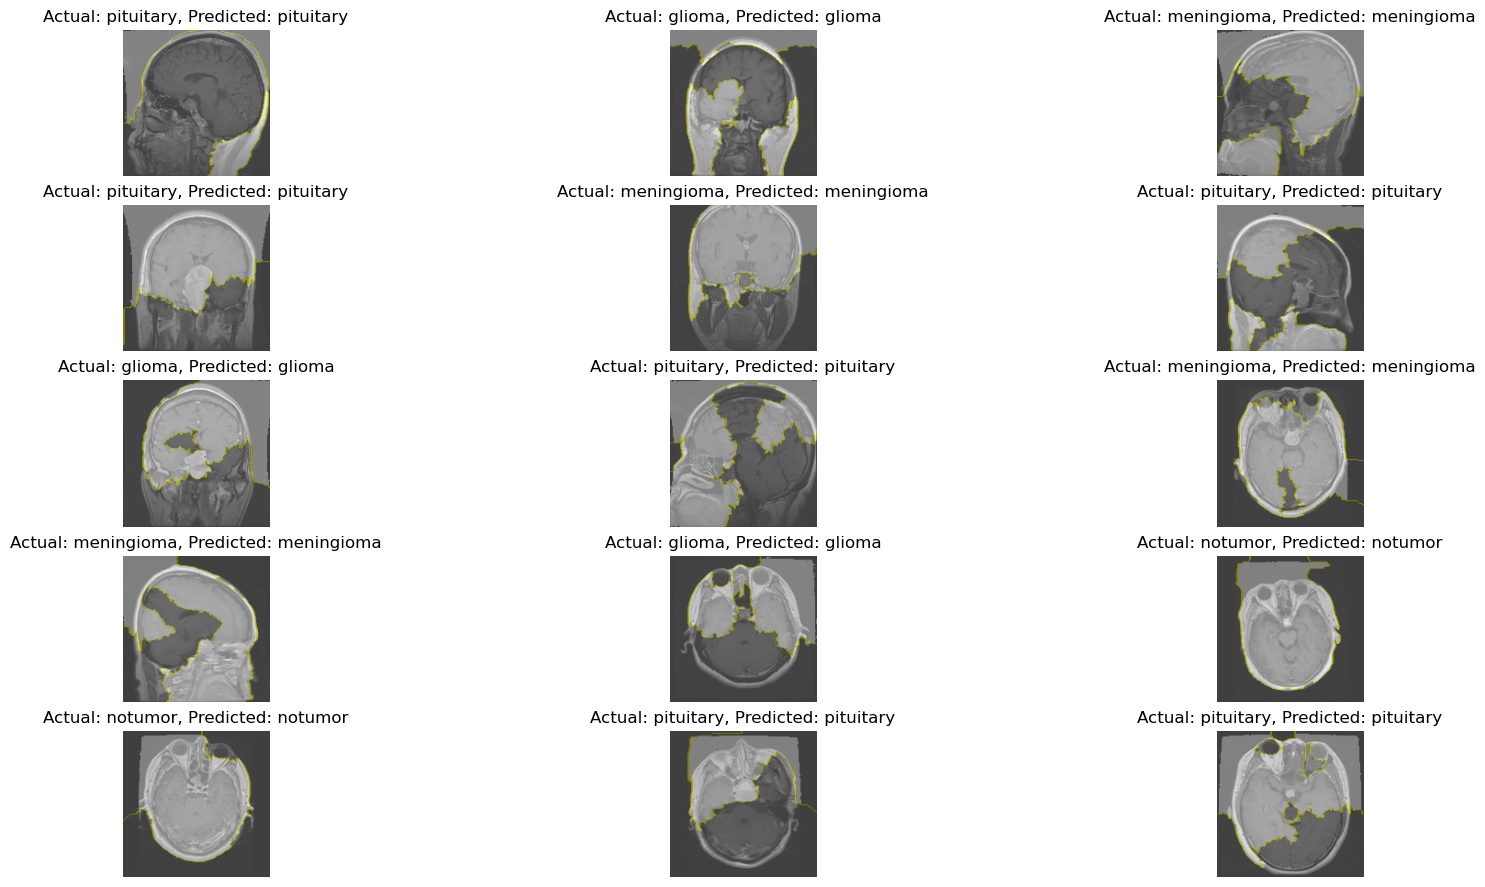

In [54]:
from lime import lime_image
from skimage.segmentation import mark_boundaries

explainer = lime_image.LimeImageExplainer()

def predict_fn(images):
    return best_model.predict(images)


plt.figure(figsize=(20, 11))

for i, (image, actual_class, predicted_class) in enumerate(zip(images, actual_classes, predicted_classes)):
    # Explain a prediction
    explanation = explainer.explain_instance(image, predict_fn, top_labels=4, num_samples=300)

    # Get the mask for the top predicted class
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)

    plt.subplot(5, 3, i + 1)
    
    plt.imshow(image, alpha=1.0)
    
    # Overlay the LIME explanation
    plt.imshow(mark_boundaries(temp / 2 + 0.5, mask), alpha=0.5)
    
    plt.title(f"Actual: {class_names[actual_class]}, Predicted: {class_names[predicted_class]}")
    plt.axis("off")

plt.show()